# Inference notenook for [CapDec](https://github.com/DavidHuji/CapDec)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/Param1K/CapDec.git
#@title Install
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-40noo9gk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-40noo9gk
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=0cc2e4e022b09343b6acfba0eaa091525413260d45734bb171f6fa563d8c695e
  Stored in directory: /tmp/pip-ephem-wheel-cache-12i8w56e/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


In [ ]:
#@title Imports
import json
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image
import math
import re
from collections import Counter

In [ ]:
!cat /content/drive/MyDrive/param1k-CapDec-light/annotations_500/val.json

[{"image_id": 184613, "caption": "A child holding a flowered umbrella and petting a yak.", "id": 474921}, {"image_id": 184613, "caption": "A young man holding an umbrella next to a herd of cattle.", "id": 479322}, {"image_id": 184613, "caption": "a young boy barefoot holding an umbrella touching the horn of a cow", "id": 479334}, {"image_id": 184613, "caption": "A young boy with an umbrella who is touching the horn of a cow.", "id": 481560}, {"image_id": 184613, "caption": "A boy holding an umbrella while standing next to livestock.", "id": 483594}, {"image_id": 403013, "caption": "A narrow kitchen filled with appliances and cooking utensils.", "id": 124166}, {"image_id": 403013, "caption": "A galley kitchen with cabinets and appliances on both sides", "id": 173825}, {"image_id": 403013, "caption": "A hallway leading into a white kitchen with appliances.", "id": 182303}, {"image_id": 403013, "caption": "Doorway view of a kitchen with a sink, stove, refrigerator and pantry.", "id": 1847

In [ ]:
images_path = '/content/drive/MyDrive/param1k-CapDec-light/data/coco/val2014/'
annotations_path = '/content/drive/MyDrive/param1k-CapDec-light/annotations_500/val.json'

In [ ]:

def get_val_image():
    image_list = os.listdir(images_path)
    # for image in image_list:
    #     print(image)
    return image_list

image_list = get_val_image()

In [ ]:

image_set = []
img_ids = []
img_annotations = []

In [ ]:

def getImages(annotations_path):
    data_mode = 0
    with open(annotations_path, 'r') as f:
        data = json.load(f)
    print("%0d captions loaded from json " % len(data))
    # print(data)
    all_embeddings = []
    all_captions = []
    all_text_embeddings = []
    long_caps = 0
    not_found = 0
    for i in tqdm(range(len(data))):
        d = data[i]
        img_id = d["image_id"]
        img_name = f"COCO_val2014_{int(img_id):012d}.jpg"

        if img_name not in image_set and img_name in image_list:
            print(img_name, d['caption'])
            image_set.append(img_name)
            img_ids.append(img_id)
            img_annotations.append(d['caption'])

getImages(annotations_path)

500 captions loaded from json 


100%|██████████| 500/500 [00:00<00:00, 41007.25it/s]

COCO_val2014_000000184613.jpg A child holding a flowered umbrella and petting a yak.
COCO_val2014_000000403013.jpg A narrow kitchen filled with appliances and cooking utensils.
COCO_val2014_000000562150.jpg A little girl holding a kitten next to a blue fence.
COCO_val2014_000000360772.jpg A toilet sitting in a bathroom next to a sink.
COCO_val2014_000000340559.jpg There are two sinks next to two mirrors.
COCO_val2014_000000321107.jpg A woman rides a bicycle on a road next to the median.
COCO_val2014_000000129001.jpg A bath tub sitting next to a sink in a bathroom.
COCO_val2014_000000556616.jpg A row of parked cars sitting next to parking meters.
COCO_val2014_000000472621.jpg An elegant bathroom features a tub, sink, mirror, and decorations. 
COCO_val2014_000000364521.jpg A red helmet is on a yellow toilet in the dirt.
COCO_val2014_000000310391.jpg A car with some surfboards in a field.
COCO_val2014_000000241876.jpg A cat on the lid of a toilet looking perturbed.
COCO_val2014_0000004623

In [ ]:



N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]

D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

In [ ]:
#@title Model

class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = 40
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = TransformerMapper(640, self.gpt_embedding_size, 40,
                                                                     40, 8)



class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)



class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [ ]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}


In [ ]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 402M/402M [00:03<00:00, 118MiB/s]


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:

#@title Mapper

class MlpTransformer(nn.Module):
    def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
        super().__init__()
        out_d = out_d if out_d is not None else in_dim
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.act = act
        self.fc2 = nn.Linear(h_dim, out_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)

class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_size: int = 640,
                 num_layers: int = 8):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = 40
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, 40,
                                                                     40, num_layers)





In [ ]:
# !pip install timm==0.6.7

In [ ]:
def jaccard_similarity(caption1, caption2):
    list1 = caption1.split(' ')
    list2 = caption2.split(' ')
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [ ]:
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


In [ ]:
model_path = '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/'

In [ ]:
model_list = os.listdir(model_path)
model_dict = {}
for model in model_list:
  model_dict[model] = model_path+model
print(model_dict)

{'coco_prefix-009-0.032.pt': '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/coco_prefix-009-0.032.pt', 'coco_prefix-009-0.016.pt': '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/coco_prefix-009-0.016.pt', 'coco_prefix-009-0.0.pt': '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/coco_prefix-009-0.0.pt', 'coco_prefix-009-0.064.pt': '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/coco_prefix-009-0.064.pt', 'coco_prefix-009-0.128.pt': '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/coco_prefix-009-0.128.pt', 'coco_prefix-029-0.016.pt': '/content/drive/MyDrive/param1k-CapDec-light/pretrained_models/coco_prefix-029-0.016.pt'}


In [ ]:
#@title Inference
#use_beam_search = True #@param {type:"boolean"}
use_beam_search = True
def gen_caption(model, img_path, caption, result):
    jacc_sim_list = result['jacc_sim_list']
    cos_sim_list = result['cos_sim_list']
    image = io.imread(img_path)
    pil_image = PIL.Image.fromarray(image)
    #pil_img = Image(filename=UPLOADED_FILE)
    device = CUDA(0) if is_gpu else "cpu"

    image = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, 40, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

    jacc_sim = jaccard_similarity(caption, generated_text_prefix)
    jacc_sim_list.append(jacc_sim)


    vector1 = text_to_vector(caption)
    vector2 = text_to_vector(generated_text_prefix)

    cosine_sim = get_cosine(vector1, vector2)
    cos_sim_list.append(cosine_sim)
    # display(pil_image)
    # print("Original Caption = ", caption)
    # print("Generated Caption = ", generated_text_prefix)
    # print("Jaccard Similarity", jacc_sim)
    # print("Cosine Similarity", cosine_sim)


In [ ]:
# image_set = []
# img_ids = []
# img_annotations = []
# images_path = '/content/drive/MyDrive/param1k-CapDec-light/data/coco/val2014/'

result = {}

#@title Load model weights
for modelName,path in model_dict.items():
  model = ClipCaptionModel()
  model.load_state_dict(torch.load(path, map_location=device), strict=False)
  model = model.eval()
  model = model.to(device)
  result[modelName] = {
    "image_set" : [],
    "jacc_sim_list" : [],
    "cos_sim_list" : []
  }
  for index in range(100):
      result[modelName]["image_set"].append(image_set[index])
      gen_caption(model, images_path+image_set[index], img_annotations[index], result[modelName])

print(result)

{'coco_prefix-009-0.032.pt': {'image_set': ['COCO_val2014_000000184613.jpg', 'COCO_val2014_000000403013.jpg', 'COCO_val2014_000000562150.jpg', 'COCO_val2014_000000360772.jpg', 'COCO_val2014_000000340559.jpg', 'COCO_val2014_000000321107.jpg', 'COCO_val2014_000000129001.jpg', 'COCO_val2014_000000556616.jpg', 'COCO_val2014_000000472621.jpg', 'COCO_val2014_000000364521.jpg', 'COCO_val2014_000000310391.jpg', 'COCO_val2014_000000241876.jpg', 'COCO_val2014_000000462341.jpg', 'COCO_val2014_000000268556.jpg', 'COCO_val2014_000000386912.jpg', 'COCO_val2014_000000074331.jpg', 'COCO_val2014_000000078371.jpg', 'COCO_val2014_000000052759.jpg', 'COCO_val2014_000000128939.jpg', 'COCO_val2014_000000339974.jpg', 'COCO_val2014_000000009426.jpg', 'COCO_val2014_000000242139.jpg', 'COCO_val2014_000000143931.jpg', 'COCO_val2014_000000040102.jpg', 'COCO_val2014_000000403020.jpg', 'COCO_val2014_000000505440.jpg', 'COCO_val2014_000000029913.jpg', 'COCO_val2014_000000431573.jpg', 'COCO_val2014_000000332654.jpg',

In [ ]:
print(result)

{'coco_prefix-009-0.032.pt': {'image_set': ['COCO_val2014_000000184613.jpg', 'COCO_val2014_000000403013.jpg', 'COCO_val2014_000000562150.jpg', 'COCO_val2014_000000360772.jpg', 'COCO_val2014_000000340559.jpg', 'COCO_val2014_000000321107.jpg', 'COCO_val2014_000000129001.jpg', 'COCO_val2014_000000556616.jpg', 'COCO_val2014_000000472621.jpg', 'COCO_val2014_000000364521.jpg', 'COCO_val2014_000000310391.jpg', 'COCO_val2014_000000241876.jpg', 'COCO_val2014_000000462341.jpg', 'COCO_val2014_000000268556.jpg', 'COCO_val2014_000000386912.jpg', 'COCO_val2014_000000074331.jpg', 'COCO_val2014_000000078371.jpg', 'COCO_val2014_000000052759.jpg', 'COCO_val2014_000000128939.jpg', 'COCO_val2014_000000339974.jpg', 'COCO_val2014_000000009426.jpg', 'COCO_val2014_000000242139.jpg', 'COCO_val2014_000000143931.jpg', 'COCO_val2014_000000040102.jpg', 'COCO_val2014_000000403020.jpg', 'COCO_val2014_000000505440.jpg', 'COCO_val2014_000000029913.jpg', 'COCO_val2014_000000431573.jpg', 'COCO_val2014_000000332654.jpg',

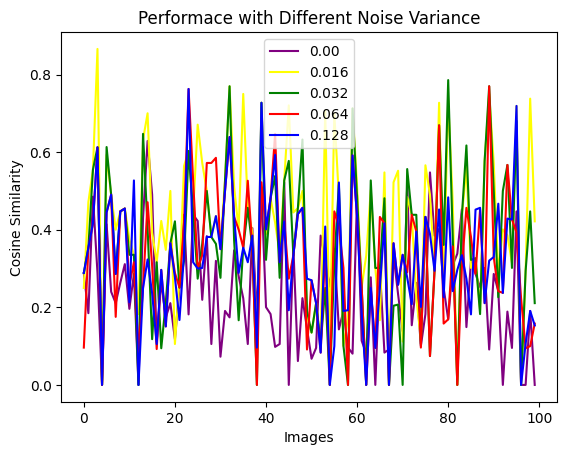

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result['coco_prefix-009-0.0.pt']['cos_sim_list'], color="purple", label='0.00')
plt.plot(result['coco_prefix-009-0.016.pt']['cos_sim_list'], color="yellow", label='0.016')
plt.plot(result['coco_prefix-009-0.032.pt']['cos_sim_list'], color="green", label='0.032')
plt.plot(result['coco_prefix-009-0.064.pt']['cos_sim_list'], color="red", label='0.064')
plt.plot(result['coco_prefix-009-0.128.pt']['cos_sim_list'], color="blue", label='0.128')
#plt.plot(result['coco_prefix-029-0.016.pt']['cos_sim_list'], ls="--", color="blue", label='0.016-30ep')
plt.plot()
plt.xlabel("Images")
plt.ylabel("Cosine Similarity")
plt.title("Performace with Different Noise Variance")
plt.legend()
plt.show()




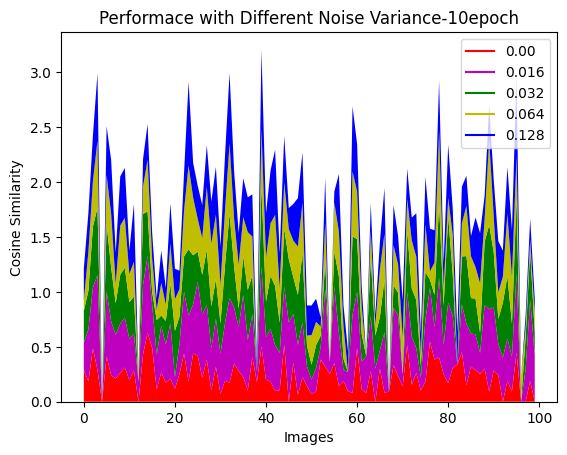

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(result['coco_prefix-009-0.0.pt']['cos_sim_list'], color="purple", label='0.00')
# plt.plot(result['coco_prefix-009-0.016.pt']['cos_sim_list'], color="blue", label='0.016')
# plt.plot(result['coco_prefix-009-0.032.pt']['cos_sim_list'], color="green", label='0.032')
# plt.plot(result['coco_prefix-009-0.064.pt']['cos_sim_list'], color="red", label='0.064')
# plt.plot(result['coco_prefix-009-0.128.pt']['cos_sim_list'], color="yellow", label='0.128')
# plt.plot(result['coco_prefix-029-0.016.pt']['cos_sim_list'], ls="--", color="blue", label='0.016-30ep')
indx = [x for x in range(100)]
# Adding legend for stack plots is tricky.
plt.plot([], [], color='r', label = '0.00')
plt.plot([], [], color='m', label = '0.016')
plt.plot([], [], color='g', label = '0.032')
plt.plot([], [], color='y', label = '0.064')
plt.plot([], [], color='b', label = '0.128')
#plt.plot([], [], color='k', label = '0.016-30ep')


plt.stackplot(indx,
              result['coco_prefix-009-0.0.pt']['cos_sim_list'],
              result['coco_prefix-009-0.016.pt']['cos_sim_list'],
              result['coco_prefix-009-0.032.pt']['cos_sim_list'],
              result['coco_prefix-009-0.064.pt']['cos_sim_list'],
              result['coco_prefix-009-0.128.pt']['cos_sim_list'],
              # result['coco_prefix-029-0.016.pt']['cos_sim_list'],
              colors= ['r', 'm', 'g','y','b','k'])
plt.xlabel("Images")
plt.ylabel("Cosine Similarity")

plt.title("Performace with Different Noise Variance-10epoch")
plt.legend()
plt.show()